<img src="regex.jpg" width="450" height="300" align="right"/>

# Data Wrangling: Create Analytic Table
  
by Christoph Güttner
  
**Abstract** First a dataframe is build out of 100_000 rows of data  
in distinct string format(different time format and different currencies).  
The goal is to get a dataframe with datetimeindex and a price column with  
comparable (expressed in terms of Euro) integer datatype.  
To create an analytic table, regular expressions are used to match distinct format  
patterns. Then, the datatype transformation is applied in each row of the  
respective df.column. Last, the resulting analytic dataframe is sorted and visualised.

In [2]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from currency_converter import CurrencyConverter
cc = CurrencyConverter()

In [3]:
def transform_to_datetime(string, pattern):
    found = re.findall(pattern, string)
    if found[0][1] =='/':
        date = datetime.strptime(string, '%d/%m/%Y')
    elif found[0][1] =='-':
        date = datetime.strptime(string, '%d-%m-%Y')
    elif found[0][1] ==' ':
        date = datetime.strptime(string, '%d %m %Y')
    else:
        print('FormatERROR: Unkown Date Formating')
    return date


def transform_to_int(string, pattern, cc):
    found = re.findall(pattern,string)
    if found[0][1]=='J':
        price= cc.convert(found[0][0], 'JPY', 'EUR') 
    elif found[0][1]=='D':
        price= cc.convert(found[0][0], 'USD', 'EUR') 
    elif found[0][1]=='E':
        price = found[0][0]
    return int(price)



## Original DataFrame

In [4]:
Price=[]
for i in range(100_000):
    currency = np.random.choice(['Dollar', 'Euro', 'Jen'])
    price = np.random.randint(0,1000)
    whitespace = np.random.choice(['',' '])
    Price.append(f'{price}{whitespace}{currency}')

In [5]:
Date=[]
for i in range(100_000):
    day = np.random.randint(1,28)
    month = np.random.randint(1,12)
    year = np.random.randint(2014,2021)
    whitespace =np.random.choice(['/','-', ' '])
    Date.append(f'{day}{whitespace}{month}{whitespace}{year}')

In [6]:
dictionary ={'Date':Date, 'Price': Price}
df= pd.DataFrame(dictionary)
df

,Date,Price
0,25/8/2015,605 Dollar
1,21-5-2016,758 Euro
2,10/2/2018,67Euro
3,4 11 2014,795Dollar
4,17/1/2016,91Jen
...,...,...
99995,4 1 2020,815Euro
99996,2/3/2019,433Dollar
99997,9-3-2020,308 Dollar
99998,15/11/2015,419 Dollar


## Check DataType

In [7]:
for i in range(5):
    print(type(df['Date'][0]), type(df['Price'][i]))


<class 'str'> <class 'str'>
<class 'str'> <class 'str'>
<class 'str'> <class 'str'>
<class 'str'> <class 'str'>
<class 'str'> <class 'str'>


## Data Wrangling and Type Formatting

Using regex

In [8]:
df_analytics = pd.DataFrame()

## Time column

In [9]:
time_pattern= re.compile('(\d+)([ /-])(\d+)([ /-])(\d+)')
df_analytics['new_Date'] = df['Date'].apply(lambda x: transform_to_datetime(x, time_pattern))

## Price Column

In [10]:
price_pattern= re.compile('(\d+)\s?([EDJ])')
df_analytics['new_Price/Euro'] = df['Price'].apply(lambda row: transform_to_int(row, price_pattern, cc))

## DataFrame For Analytics

In [11]:
df_analytics

,new_Date,new_Price/Euro
0,2015-08-25,508
1,2016-05-21,758
2,2018-02-10,67
3,2014-11-04,668
4,2016-01-17,0
...,...,...
99995,2020-01-04,815
99996,2019-03-02,364
99997,2020-03-09,258
99998,2015-11-15,352


## Check DataType again

In [12]:
for i in range(5):
    print(type(df_analytics['new_Date'][0]), type(df_analytics['new_Price/Euro'][i]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'numpy.int64'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'numpy.int64'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'numpy.int64'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'numpy.int64'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'numpy.int64'>


## Sort and set Index

In [13]:
df_analytics= df_analytics.sort_values(by = 'new_Date')
df_analytics.set_index('new_Date', inplace=True)


In [14]:
df_analytics.resample('D').agg({'new_Price/Euro': 'mean'})

,new_Price/Euro
new_Date,
2014-01-01,236.386364
2014-01-02,264.775000
2014-01-03,297.163265
2014-01-04,330.019608
2014-01-05,282.769231
...,...
2020-11-23,338.745455
2020-11-24,299.519231
2020-11-25,359.100000


## Visualise Dataframe

Text(0.5, 1.0, 'Ready for Analytics')

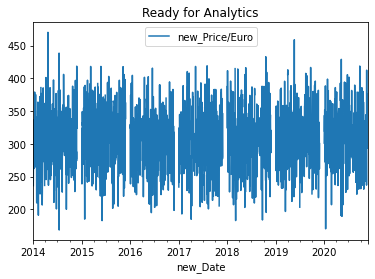

In [15]:
df_analytics.resample('D').agg({'new_Price/Euro': 'mean'}).plot()
plt.title('Ready for Analytics')
